## CIFAR-10 dataset

#### The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.

#### <b>Your task is to create an autoencoder to encode images and then decode them.</b>
---



#### Importing the necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from tqdm import tqdm

#### Dataset Preparation

In [ ]:
# Normalizing the pixel values between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale()
])

# Loading and preprocessing the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Splitting the dataset into training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12649536.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Image's shape.
next(iter(train_loader))[0][0].shape

torch.Size([1, 32, 32])

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(32 * 32, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),

            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, dim),
            nn.Tanh()
        )

        self.Decoder = nn.Sequential(
            nn.Linear(dim, 128),
            nn.LeakyReLU(),

            nn.Linear(128, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        original_shape = x.shape

        x = torch.flatten(x, start_dim=1)
        x = self.Encoder(x)
        x = self.Decoder(x)

        x = x.view(original_shape)

        return x

In [ ]:
dim = 64
model = AutoEncoder(64)
summary(model, (1, 32, 32), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         524,800
         LeakyReLU-2                  [-1, 512]               0
       BatchNorm1d-3                  [-1, 512]           1,024
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
            Linear-7                  [-1, 128]          32,896
         LeakyReLU-8                  [-1, 128]               0
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                   [-1, 64]           8,256
             Tanh-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 12
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [ ]:
train_losses = []
for epoch in range(epochs):
    losses = 0
    for x_batch, _ in train_loader:
        x_batch.view(-1, 32*32).to(device)

        x_pred = model(x_batch)

        loss = criterion(x_pred, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses += loss.item() * len(x_batch)
    epoch_loss = losses / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch}/{epochs}: Loss={epoch_loss}')



Epoch 0/12: Loss=0.18432903895378114
Epoch 1/12: Loss=0.16843178013801574
Epoch 2/12: Loss=0.16182419964790346
Epoch 3/12: Loss=0.15964683831214904
Epoch 4/12: Loss=0.157455027217865
Epoch 5/12: Loss=0.15547508168697358
Epoch 6/12: Loss=0.15405485097408295
Epoch 7/12: Loss=0.15259506954431534
Epoch 8/12: Loss=0.15158298841953277
Epoch 9/12: Loss=0.1509632878780365
Epoch 10/12: Loss=0.15008489985466003
Epoch 11/12: Loss=0.14927643446922303


Text(0, 0.5, 'Loss(MSE)')

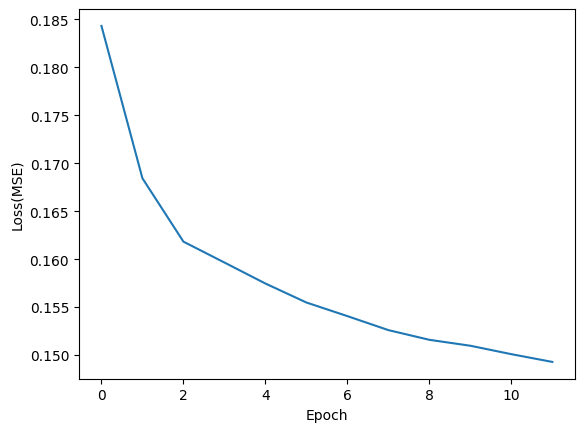

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss(MSE)')

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im, cmap="gray")
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

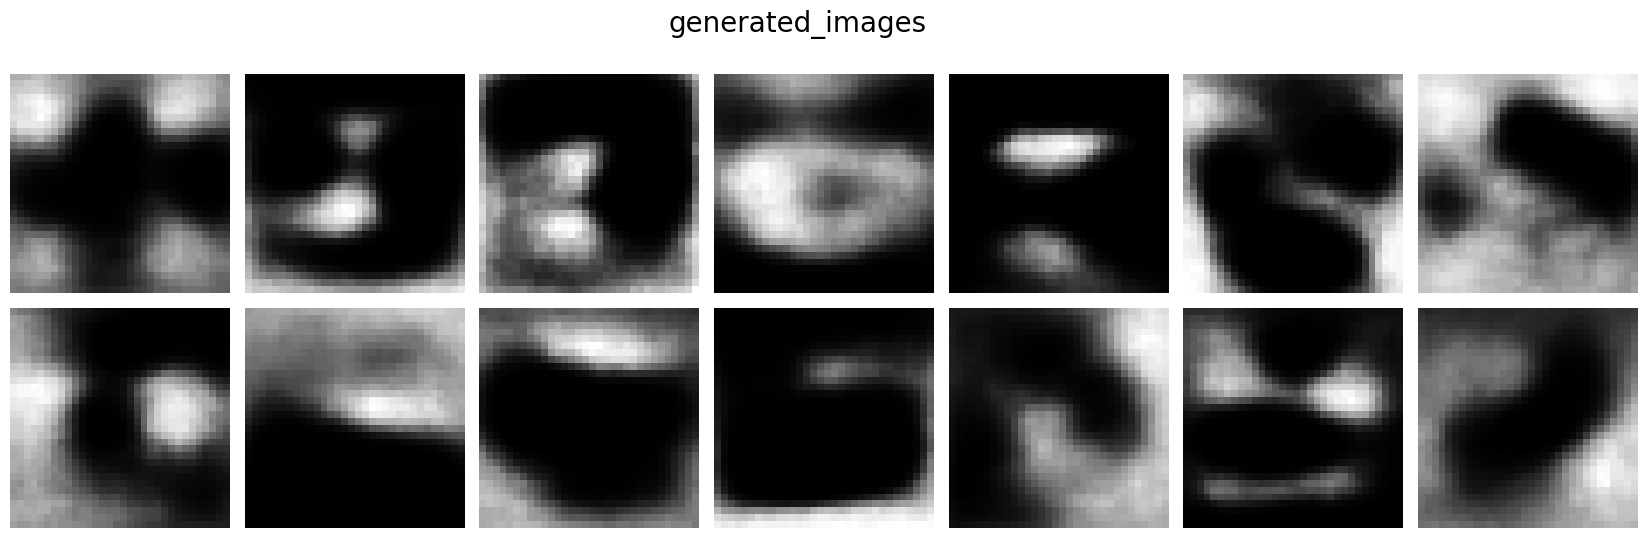

In [ ]:
rows, cols = 2, 7
sample_encodings = (torch.rand(rows * cols, dim).to(device) - 0.5) * 2  # encoding space: [-1, 1)

with torch.no_grad():
    model.to(device)
    generations = model.Decoder(sample_encodings).cpu()
    generations = generations.reshape(-1, 32, 32, 1)
display_image_grid(generations, rows, cols, "generated_images")